## Prompt and actions on Questions


* Look at `registrants` Table in postgres
* Fetch the region/neignourhood in the query.
* Get all the block groups under the neigbourhood using neigbbourhood-block group mapping file created using overlay layer between them.
* Create bounding box extent with the region as centre of San Diego County.
* Highlight the block groups relevant for our region.
* Classify the block groups according to a score or rank created using combination of variables.

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, FeatureLayerCollection, GeoAccessor
from arcgis.geocoding import geocode
from arcgis.geometry import buffer, Point

import pandas as pd

import sys
sys.path.append('../../')
from utils import get_config

In [2]:
username = get_config("arcgis","username")
password = get_config("arcgis","passkey")
gis = GIS("https://ucsdonline.maps.arcgis.com/home", username=username, password=password)

### Check if the user belongs to a Food desert

#### Check meal_gap or CalFresh data to check Food insecurity rate for some radius of area
* Map the meal gap data is at County level, not sure if it is really helpful for us.
* CalFresh Data might need to be standardized, but it is on zip level.

##### Can we query a geography within a certain radius of a location.

##### Can we get list of block groups given a region. For now we will consider planned community areas.

#### Option 1

In [ ]:
## Get the relevant block groups
region_of_interest = 'RANCHO PENASQUITOS'
region_of_interest = region_of_interest.lower()
cpa_bg_map = pd.read_csv("../resources/san_diego_county_cpa_blk_grp_map.csv", dtype ='str')
mask = cpa_bg_map['CPANAME']==region_of_interest
block_groups_in_region = cpa_bg_map[mask]
block_groups_in_region_list = block_groups_in_region['fips'].tolist()

In [3]:
# Query the block group for respective variables and feature layer.
variables = "demographics"
if variables=="demographics":
    url = "https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/aff1b6/FeatureServer/0"
ft_lyr = FeatureLayer(gis=gis,
                       url=url)
out_fields = ["fips", "occeduc_cy","pif60_cy","OCCFOOD_CY"]  

In [6]:
where = "fips IN (" + ",".join(block_groups_in_region_list) + ")"
#print(where)
result_rows = ft_lyr.query(
    where=where,
    out_fields=out_fields,
    return_geometry=True,
    as_df=True,
)
result_rows.head(2)

,FID,fips,occeduc_cy,pif60_cy,occfood_cy,SHAPE
0,508,060730170181,41.0,2.0,82.0,"{""rings"": [[[-13035625.351, 3890389.58830002],..."
1,509,060730170182,28.0,0.0,77.0,"{""rings"": [[[-13035887.7309999, 3888939.776800..."


#### Option 2

In [4]:
registrant_address = "11010 Caminito Alvarez, San Diego, 92126"
matched_registrant_address = geocode(address=registrant_address,
                 max_locations = 1
                )
# matched_registrant_address

In [5]:
#matched_registrant_address

In [6]:
lat_long = [matched_registrant_address[0]['location']['x'],matched_registrant_address[0]['location']['y']]
address_score = matched_registrant_address[0]['score']
address_identified = matched_registrant_address[0]['address']
print(f"Important Fields: \n Address Matched: {address_identified} \n Latitude,Longitude: {lat_long}\n Match SCore: {address_score}")

Important Fields: 
 Address Matched: 11010 Caminito Alvarez, San Diego, California, 92126 
 Latitude,Longitude: [-117.1675950182451, 32.90706625343636]
 Match SCore: 100


In [16]:
point_location = matched_registrant_address[0]['location']
print(f"point_location: {point_location}")
point_geom = Point({"x": point_location['x'], "y": point_location['y'], "spatialReference" : {
      "wkid": 102100,
      "latestWkid": 3857
    }})

## This buffer query was failing because ESRI takes constant values instead of names for unit.
# So here 9035 is Value for constant esriSRUnit_SurveyMile	which is described as 'US Survey Mile'
# Link for more constants: http://resources.arcgis.com/en/help/arcobjects-cpp/componenthelp/index.html#/esriSRUnitType_Constants/000w00000042000000/
buffer_geom = buffer(geometries=[point_geom], distances=5.0, unit='9035', in_sr={
      "wkid": 102100,
      "latestWkid": 3857
    })


point_location: {'x': -117.1675950182451, 'y': 32.90706625343636}


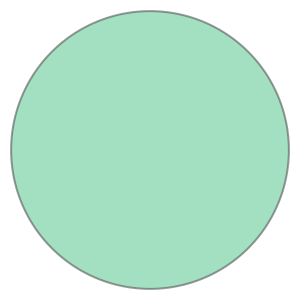

In [17]:
buffer_geom[0]

In [18]:
from arcgis.geometry.filters import intersects
buffer_filter = intersects(buffer_geom[0],{
      "wkid": 102100,
      "latestWkid": 3857
    })


In [19]:
buffer_filter['inSR']

{'wkid': 102100, 'latestWkid': 3857}

In [20]:
features_df = ft_lyr.query(geometry_filter=buffer_filter,as_df=True)
features_df

,FID,fips,blkf20_cy,mage69_fy,whtm5_cy,pif60_cy,asn10_fy,occeduc_cy,oldrgenscy,medoage_cy,...,male55_fy,mage16_fy,age71_fy,medmmagefy,hagebasefy,othf35_fy,a65i0_cy,Shape__Area,Shape__Length,SHAPE


In [92]:
# Define the spatial relationship for the query
spatial_relationship = "esriSpatialRelIntersects"

# Define the query parameters
query_params = {"geometry": buffer_geom, "geometryType": "esriGeometryPoint", "inSR": 3857, "spatialRel": spatial_relationship}

result_rows_2 = ft_lyr.query(
    where="1=1",
    #out_fields=out_fields,
    return_geometry=True,
    as_df=True,
    **query_params
)
result_rows_2.head(2)


,FID,fips,blkf20_cy,mage69_fy,whtm5_cy,pif60_cy,asn10_fy,occeduc_cy,oldrgenscy,medoage_cy,...,male55_fy,mage16_fy,age71_fy,medmmagefy,hagebasefy,othf35_fy,a65i0_cy,Shape__Area,Shape__Length,SHAPE


In [73]:
# from arcgis.mapping import symbol

# colormaps = symbol.ALLOWED_CMAPS
# for a,b,c,d,e in zip(colormaps[::5], colormaps[1::5], colormaps[2::5], colormaps[3::5], colormaps[4::5]):
#     print("{:<20}{:<20}{:<20}{:<20}{:<}".format(a,b,c,d,e))


In [74]:
# from arcgis.mapping import display_colormaps
# display_colormaps(['Greens_r', 'PRGn', 'Dark2', 'Set1'])
# display_colormaps(colormaps[1::5])

#### Check Food Swamp: Desnsity of fast food and Convenience Store

#### Does this have Highly Palatable Food.

#### e.g. Mexican Food business in Chula Vista and business type as Food Truck. (Business type data to be picked up from where? )

#### Render a map

True